# Data Preprocessing

## 1. Importing Libraries & Reading Data

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import KNNImputer

# Making initial settins
pd.set_option('display.max_colwidth', None) # Display DataFrames columns in full width

In [2]:
df = pd.read_csv('data/telecom_customer_churn.csv')
df_dict = pd.read_csv('data/telecom_data_dictionary.csv', encoding='cp1252')

# 2. Inspecting Data

## 2.1 Viewing Data

In [3]:
df_dict.iloc[:,0:3]

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customer’s gender: Male, Female"
2,Customer Churn,Age,"The customer’s current age, in years, at the time the fiscal quarter ended (Q2 2022)"
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,"Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)"
5,Customer Churn,City,The city of the customer’s primary residence in California
6,Customer Churn,Zip Code,The zip code of the customer’s primary residence
7,Customer Churn,Latitude,The latitude of the customer’s primary residence
8,Customer Churn,Longitude,The longitude of the customer’s primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has referred a friend or family member to this company to date


In [4]:
df.shape

(7043, 38)

In [5]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [7]:
df.nunique()

Customer ID                          7043
Gender                                  2
Age                                    62
Married                                 2
Number of Dependents                   10
City                                 1106
Zip Code                             1626
Latitude                             1626
Longitude                            1625
Number of Referrals                    12
Tenure in Months                       72
Offer                                   5
Phone Service                           2
Avg Monthly Long Distance Charges    3583
Multiple Lines                          2
Internet Service                        2
Internet Type                           3
Avg Monthly GB Download                49
Online Security                         2
Online Backup                           2
Device Protection Plan                  2
Premium Tech Support                    2
Streaming TV                            2
Streaming Movies                  

In [8]:
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


## 2.2 Checking which columns/rows to drop and which to fix:
There are 38 columns which is a lot of features

### 2.2.1 Info vs Nunique vs Unique Values vs Nulls Percentage
Viweing info beside N-Unique values and unique values for better comparison and further inspection before final decision

In [9]:
def info_plus(df):
    '''
    Displays info() beside # Nulls, # Unique values, First 5 Unique values, and Nulls % 

    Args:
    df: DataFrame 
    
    Returns:
    info_plus_df: DataFrame of df.columns as rows and info() plus unique value info as columns
    '''
    info_plus = [[k, df[k].notnull().sum(), df[k].isnull().sum(), df[k].dtypes, df[k].nunique(),\
                  (df[k].unique().tolist()[:5]), int(df[k].isnull().sum()/len(df[k])*100)] for k in df.columns]
    info_plus_df = pd.DataFrame(info_plus, columns=['Column', 'Non-Null', 'Nulls', 'DType', 'N Unique',\
                                                    'First 5 Unique', '% Missing'])
    return info_plus_df

df_info = info_plus(df)
df_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Customer ID,7043,0,object,7043,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKFF, 0013-EXCHZ]",0
1,Gender,7043,0,object,2,"[Female, Male]",0
2,Age,7043,0,int64,62,"[37, 46, 50, 78, 75]",0
3,Married,7043,0,object,2,"[Yes, No]",0
4,Number of Dependents,7043,0,int64,10,"[0, 3, 1, 2, 4]",0
5,City,7043,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
6,Zip Code,7043,0,int64,1626,"[93225, 91206, 92627, 94553, 93010]",0
7,Latitude,7043,0,float64,1626,"[34.827662, 34.162515, 33.645672, 38.014457, 34.227846]",0
8,Longitude,7043,0,float64,1625,"[-118.999073, -118.203869, -117.922613, -122.115432, -119.079903]",0
9,Number of Referrals,7043,0,int64,12,"[2, 0, 1, 3, 8]",0


In [10]:
df_info[df_info['Nulls'] > 0]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
11,Offer,3166,3877,object,5,"[nan, Offer E, Offer D, Offer A, Offer B]",55
13,Avg Monthly Long Distance Charges,6361,682,float64,3583,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
14,Multiple Lines,6361,682,object,2,"[No, Yes, nan]",9
16,Internet Type,5517,1526,object,3,"[Cable, Fiber Optic, DSL, nan]",21
17,Avg Monthly GB Download,5517,1526,float64,49,"[16.0, 10.0, 30.0, 4.0, 11.0]",21
18,Online Security,5517,1526,object,2,"[No, Yes, nan]",21
19,Online Backup,5517,1526,object,2,"[Yes, No, nan]",21
20,Device Protection Plan,5517,1526,object,2,"[No, Yes, nan]",21
21,Premium Tech Support,5517,1526,object,2,"[Yes, No, nan]",21
22,Streaming TV,5517,1526,object,2,"[Yes, No, nan]",21


# 3. Cleaning Data

**Rows to Modify or Drop:**
1. Duplicated rows
2. Rows with missing values less than 5%
3. Rows or data entries not related to churn/not churn: Customer status "Joined" rows -> Drop rows if small % or turn into "Stayed" if more than 5%

## 3.1 Dopping Rows:

### 3.1.1 Drop Duplicates
**Findings**: No duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

### 3.1.2 Drop Missing Value rows
**Findings**: There are no variables with less than %5 to be dropped

### 3.1.3 Handling "Joined" rows in Customer Status Column

In [12]:
print(f'"Joined"% in Cusomer Status = %{(df["Customer Status"] == "Joined").sum().item()/df.shape[0]*100}')
print('Can either be dropped or changed to "Stayed"')

"Joined"% in Cusomer Status = %6.446116711628568
Can either be dropped or changed to "Stayed"


**Findings:**
- **Q1:** What are Tenure in Months values that correspond to Customer Status "Joined" values? <br>
    - **A1:** 1, 2, and 3 months
- **Q2:** How many records with Customer Status values "Churned" that correspond to the same Tenure in Months values found for "Joined" values?
    - Tenure 1: # Churned 380  |  # Joined 233 <br>
      Tenure 3: # Churned 094  |  # Joined 106 <br>
      Tenure 2: # Churned 123  |  # Joined 115
- Since a Joined subscriber can be considered Churned if he unsubscribes in the first 3 months, we can consider Joined subscribers as saved ones.
- Thus, we will replace "Joined" with "Stayed" in the Customer Status column.

In [13]:
# A1
df[df['Customer Status'] == 'Joined']['Tenure in Months'].value_counts()

Tenure in Months
1    233
2    115
3    106
Name: count, dtype: int64

In [14]:
# A2
joined_tenure = df[df['Customer Status'] == 'Joined']['Tenure in Months'].unique().tolist()

for i in joined_tenure:
    i_join = ((df['Customer Status'] == 'Joined') & (df['Tenure in Months'] == i)).sum()
    i_churn = ((df['Customer Status'] == 'Churned') & (df['Tenure in Months'] == i)).sum()
    print(f'Tenure {i}: # Churned {i_churn:03}  |  # Joined {i_join}')

Tenure 1: # Churned 380  |  # Joined 233
Tenure 3: # Churned 094  |  # Joined 106
Tenure 2: # Churned 123  |  # Joined 115


- Replace "Joined" with "Stayed" in Customer Status Column

In [15]:
df2 = df.copy()

# Replace "Joined" by "Stayed"
df2['Customer Status'] = df2['Customer Status'].str.replace('Joined','Stayed')
info_plus(df2).iloc[35:37,:]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
35,Customer Status,7043,0,object,2,"[Stayed, Churned]",0
36,Churn Category,1869,5174,object,5,"[nan, Competitor, Dissatisfaction, Other, Price]",73


## 3.2 Drop Columns
**Findings**: Columns/Rows to Modify or Drop:
1. Drop irrelevant columns:
    - Customer ID
    - Online Security
    - Online Backup
    - Paperless Billing
    - Payment Method
2. Columns with too many unique values and can't be categorized:
    - Latitude, Longitude, Zip Code -> Drop
    - City (vital) -> Keep
3. Columns with too many missing values (over %50 Nulls):
   - Offers -> Drop
   - Churn Category -> Drop
   - Churn Reason -> Drop
4. Related columns (highly correlated): Monthly charge, total charges -> Drop 1
5. Related columns (highly correlated): total refunds, total extra data charges, total long distance charges, total revenue -> Drop some
6. Related columns (highly correlated): Average Monthly Long Distance Charges, Total Long Distance Charges -> Drop 1

7. Columns that can be combined: Streaming TV, Streaming Movies, Streaming Music -> Merge

### 3.2.1 Columns: Customer ID, Latitude, Longitude, Zip Code, Offers, Churn Category, Churn Reason  

- Drop Columns

In [16]:
df2.drop(['Customer ID', 'Online Security', 'Online Backup', 'Paperless Billing', 'Payment Method', 'Longitude',\
          'Latitude', 'Zip Code', 'Offer', 'Churn Category', 'Churn Reason'], axis=1, inplace=True)
info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,7043,0,object,2,"[Female, Male]",0
1,Age,7043,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,7043,0,object,2,"[Yes, No]",0
3,Number of Dependents,7043,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,7043,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,7043,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,7043,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,7043,0,object,2,"[Yes, No]",0
8,Avg Monthly Long Distance Charges,6361,682,float64,3583,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
9,Multiple Lines,6361,682,object,2,"[No, Yes, nan]",9


### 3.2.2 Columns: Monthly Charge, Total Charges
**Findings**: 
- From the table below, Total Charges column values are almost equal to Monthly Charges Multiplied by Tenure in Months (except for the rows with outlier Monthly Charges)
- Hence, we'll keep one of them. And since the rest all financial charges are calculated till last quarter, we'll drop the Monthly Charge column.
- Another reason to remove the Montly Charge column is that it has outliers while the Total Charges column doesn't.

In [17]:
df2['Total / (Tenure x Monthly)'] = df2['Total Charges'] / df2['Tenure in Months'] / df2['Monthly Charge']
df2[['Tenure in Months','Monthly Charge', 'Total Charges', 'Total / (Tenure x Monthly)']].head(10)

,Tenure in Months,Monthly Charge,Total Charges,Total / (Tenure x Monthly)
0,9,65.60,593.30,1.004912
1,9,-4.00,542.40,-15.066667
2,4,73.90,280.85,0.950101
3,13,98.00,1237.85,0.971625
4,3,83.90,267.40,1.062376
5,9,69.40,571.45,0.914906
6,71,109.70,7904.25,1.014836
7,63,84.65,5377.80,1.008410
8,7,48.20,340.35,1.008743
9,65,90.45,5957.90,1.013378


- To have a more comprehensive view, lets get the stats and draw a scatterplot for the columns above

In [18]:
df2[['Tenure in Months','Monthly Charge', 'Total Charges', 'Total / (Tenure x Monthly)']].describe()

,Tenure in Months,Monthly Charge,Total Charges,Total / (Tenure x Monthly)
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.386767,63.596131,2280.381264,0.635825
std,24.542061,31.204743,2266.220462,4.131427
min,1.000000,-10.000000,18.800000,-99.658333
25%,9.000000,30.400000,400.150000,0.978070
50%,29.000000,70.050000,1394.550000,1.000000
75%,55.000000,89.750000,3786.600000,1.018938
max,72.000000,118.750000,8684.800000,1.573454


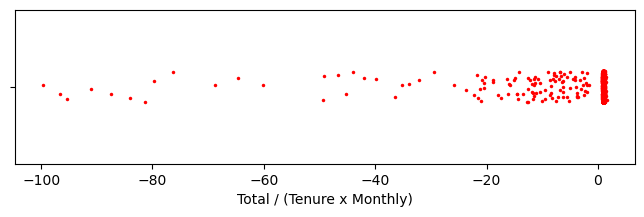

In [19]:
plt.figure(figsize=(8,2))
sns.stripplot(data=df2['Total / (Tenure x Monthly)'], orient='h', marker='.', color='red');

In [20]:
perc = len(df2[(df2['Total / (Tenure x Monthly)'] > 0.95) & (df2['Total / (Tenure x Monthly)'] < 1.05)])/len(df2) * 100
print(f'The percentage of values in the Total / (Tenure x Monthly) column that\'s between 0.95 & 1.05 is {perc}')

The percentage of values in the Total / (Tenure x Monthly) column that's between 0.95 & 1.05 is 79.11401391452506


**Findings**: 
- The Total/(Tenure x Month) column has a mean is 0.63, this is because of the outliers
- The median is 1.00 because it isn't influenced by outliers as much.
- Inspite of outlier's presence, we find that 50% of values are approximately 1.0 (between Q1 & Q3)
- %80 of the column values fall between 0.95 and 1.05, and the rest 20% are the negative outliers of Monthly Charge column which are the scattered points in the negative range.
- We will remove the Montly Charge column since it can be calculated using the other 2 columns if needed. Another reason to remove it is that because it is monthly and the rest of the charges are totals till quarter.
- So, we will drop the Monthly Charge Column

In [21]:
df2.drop(['Monthly Charge', 'Total / (Tenure x Monthly)'], axis=1, inplace=True)

### 3.2.3 Columns: Total refunds, Total extra data charges, Total long distance charges, Total Revenue
**Findings**: 
- From the Dicionary csv file (displayed at the beginning of the notebook): <br>
**Total Revenue = Total Charges - Total Refunds + Total Extra Data Charges + Total Long Distance Charges**
- To avoid multicollinearity, So we can remove total revenue or the other 4 values.
- However, since charges can be of great significance in a client's churn decision, we'll remove the Total Revenue column and keep the other 4.

In [22]:
print(list(range(1,5)))

[1, 2, 3, 4]


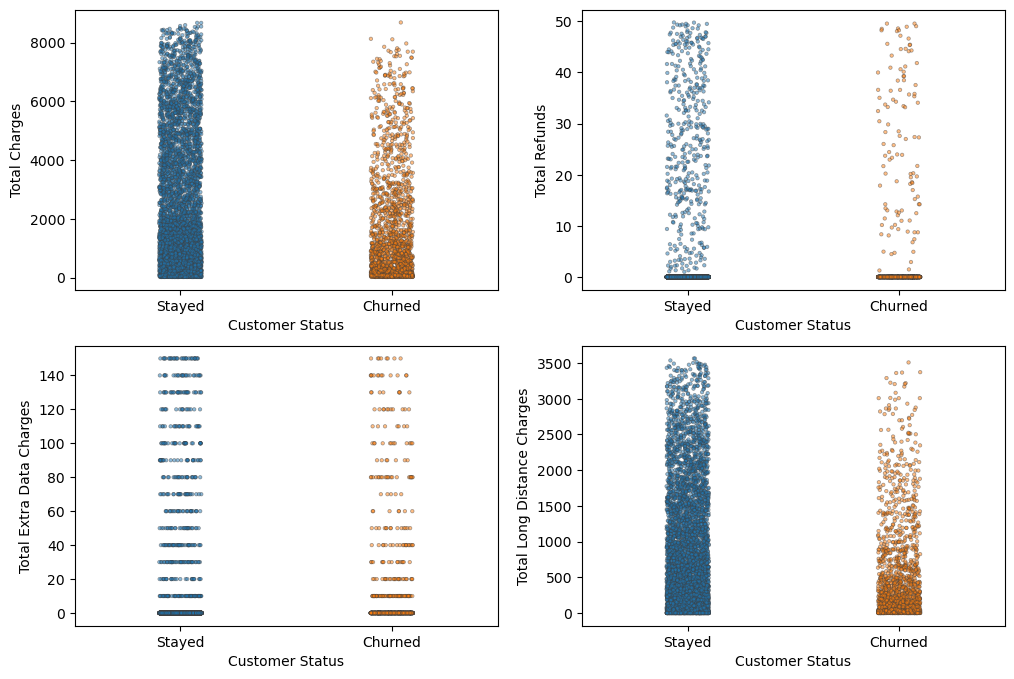

In [23]:
data = df2[['Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Customer Status']]

figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for plot in range(4):
    i = plot // 2
    j = plot % 2
    sns.stripplot(data=data, x='Customer Status', y=data.columns[plot], ax=ax[i,j], hue='Customer Status', linewidth=0.5,\
                  alpha=0.5, marker='.')


- From the above stripplot we can see from the density of points that every variable (column) has a somewhat a coorelation with the Customer Status column. Hence, we will only drop the Total Revenue column.

In [24]:
df2.drop('Total Revenue', axis=1, inplace=True)

### 3.2.4 Columns: Average Monthly Long Distance Charges, Total Long Distance Charges
**Findings**: 
- The Avg Monthly Long Distance Charges and the Total Long Distance Charges columsn can be calculated from each other directly.
- So we will drop one of them to avoid multicollinearity.

In [25]:
df2['Total / (Tenure x Monthly)'] = df2['Total Long Distance Charges'] / df2['Tenure in Months'] / \
                                    df2['Avg Monthly Long Distance Charges']
df2[['Tenure in Months', 'Avg Monthly Long Distance Charges', 'Total Long Distance Charges', \
'Total / (Tenure x Monthly)']].head()

,Tenure in Months,Avg Monthly Long Distance Charges,Total Long Distance Charges,Total / (Tenure x Monthly)
0,9,42.39,381.51,1.0
1,9,10.69,96.21,1.0
2,4,33.65,134.60,1.0
3,13,27.82,361.66,1.0
4,3,7.38,22.14,1.0


**Findings**: 
- Similar to the previous section, the Avg Monthly Long Distance Charges and the Total Long Distance Charges columsn can be calculated from each other directly.
- So we will drop one of them to avoid multicollinearity.
- We chose to drop the Avg Monthly Long Distance Charges for two reasons:
  1. It has 9 missing values while the Total Long Distance Charges column doesn't have any.
  2. The Total Long Distance Charges column has already been chosen for keep in the previous section.


In [26]:
df2.drop(['Avg Monthly Long Distance Charges', 'Total / (Tenure x Monthly)'], axis=1, inplace=True)

### 3.2.5 Columns: Streaming TV, Streaming Movies, Streaming Music
**Findings**: 
- Since these 3 columns might be related, we will combine them as a column called 'Streaming Services', which take values of 0 -> 3 depending on the number of services the client applied for.
- If we found them to be related or insignificant all together, we will combine them in the feature engineering phase after the dealing with the missing values, since each of them has a 1344 missing values.

Checking if the 1526 (%21) nulls appear in the same rows for the 3 streaming columns

In [27]:
len(df2[df2['Streaming TV'].isnull() & df2['Streaming Movies'].isnull() & df2['Streaming Music'].isnull()])

1526

In [28]:
info_plus(data)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Total Charges,7043,0,float64,6540,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
1,Total Refunds,7043,0,float64,500,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
2,Total Extra Data Charges,7043,0,int64,16,"[0, 10, 20, 40, 120]",0
3,Total Long Distance Charges,7043,0,float64,6068,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
4,Total Revenue,7043,0,float64,6975,"[974.81, 610.28, 415.45, 1599.51, 289.54]",0
5,Customer Status,7043,0,object,2,"[Stayed, Churned]",0


## 3.3 Handling Outliers:
**Findings:** We separate numerical columns into two categories for two boxplots (Small values & Large Value categories) to get a more descriptive view.
- From small value columns BoxPlot: Age, Number of Dependants, and Tenure in Months columns seem to have no outliers. 
- Although the small values boxplot shows outliers in Number of Referrals columns, from the stats description the maximum value in that column is 11 which is reasonable. So, no outliers here as well.
- The BoxPlots shows that Avg Monthly GB Download and Total Extra Data Charges columns have outliers. However, these values are also resonable:
    1. For Total Extra Data Charges column: Older subuscribers (high Tenure in Months values) have more total (cummulative) for their services.
    2. For Avg Monthly GB Download: These are average monthly values which has no relation to how old the customer subscription. But it also can be explained as some users have excessive internet usage compared to others.



### 3.3.1 Detecting Outliers

In [29]:
df2.describe()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly GB Download,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges
count,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,32.386767,26.189958,2280.381264,1.962182,6.860713,749.099262
std,16.750352,0.962802,3.001199,24.542061,19.586585,2266.220462,7.902614,25.104978,846.660055
min,19.000000,0.000000,0.000000,1.000000,2.000000,18.800000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,9.000000,13.000000,400.150000,0.000000,0.000000,70.545000
50%,46.000000,0.000000,0.000000,29.000000,21.000000,1394.550000,0.000000,0.000000,401.440000
75%,60.000000,0.000000,3.000000,55.000000,30.000000,3786.600000,0.000000,0.000000,1191.100000
max,80.000000,9.000000,11.000000,72.000000,85.000000,8684.800000,49.790000,150.000000,3564.720000


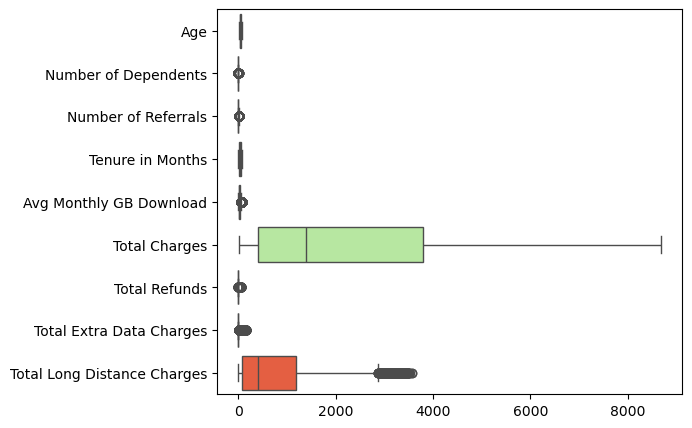

In [30]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df2, orient='h', palette='rainbow');

### 3.3.2 Separate Columns into Two Categories: Small Values & Large Values
 After Splitting the columns into two groups, we make a boxplot for each group individually

In [31]:
# selecting only numerical columns for boxplot
df_num_cols = df2.select_dtypes(include='number')

# create the two numerical columns groups
cols = list(df_num_cols.columns)
cols_small = cols[0:5] + cols[6:8]
cols_large = [cols[5], cols[8]]
print('Small values columns are:\n',cols_small)
print('Large values columns are:\n',cols_large)

Small values columns are:
 ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly GB Download', 'Total Refunds', 'Total Extra Data Charges']
Large values columns are:
 ['Total Charges', 'Total Long Distance Charges']


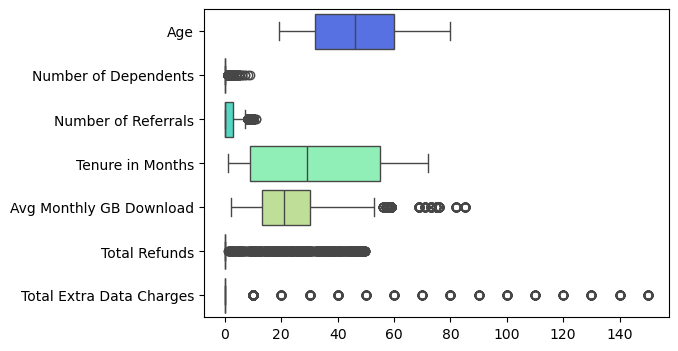

In [32]:
# Small Value Data Columns Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=df2[cols_small], orient='h', palette='rainbow');

**Findings:**
- Age, Number of Dependants, and Tenure in Months columns: seem to have no outliers. 
- Number of Referrals column and Avg Monthly GB Download: shows outliers.

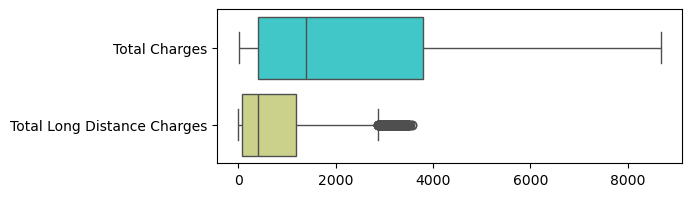

In [33]:
# Large Value Data Columns Boxplot
plt.figure(figsize=(6,2))
sns.boxplot(data=df2[cols_large], orient='h', palette='rainbow');

**Findings**: Total Long Distance Charges column has outliers.

### 3.3.3 For each category check the percentage of outliers to the total data

- Outlier Percentages in Each Column

In [34]:
# Numerical Columns
num_cols = df2.select_dtypes(include='number').columns
for col in num_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1

    LB = Q1 - 1.5 * IQR # lower bound
    if df2[col].min() > LB:
        LB = df2[col].min()

    UB = Q3 + 1.5 * IQR # upper bound
    if df2[col].max() < UB:
        UB = df2[col].max()
    
    filter = (df2[col] < LB) | (df2[col] > UB) 
    no_rows = df2[filter].shape[0]
    outlier_per = df2[filter].shape[0] / df2.shape[0] * 100
    
    print(f'Column: {df2[col].name}\n\
    Q1 = {Q1}    Q3 = {Q3}    IQR = {IQR}\n\
    min = {df2[col].min()}    Lower Bound = {LB}\n\
    max = {df2[col].max()}    Upper Bound = {UB}\n\
    # Outlier Rows={no_rows}    % Outliers: %{outlier_per:.0f}\n')

Column: Age
    Q1 = 32.0    Q3 = 60.0    IQR = 28.0
    min = 19    Lower Bound = 19
    max = 80    Upper Bound = 80
    # Outlier Rows=0    % Outliers: %0

Column: Number of Dependents
    Q1 = 0.0    Q3 = 0.0    IQR = 0.0
    min = 0    Lower Bound = 0.0
    max = 9    Upper Bound = 0.0
    # Outlier Rows=1627    % Outliers: %23

Column: Number of Referrals
    Q1 = 0.0    Q3 = 3.0    IQR = 3.0
    min = 0    Lower Bound = 0
    max = 11    Upper Bound = 7.5
    # Outlier Rows=676    % Outliers: %10

Column: Tenure in Months
    Q1 = 9.0    Q3 = 55.0    IQR = 46.0
    min = 1    Lower Bound = 1
    max = 72    Upper Bound = 72
    # Outlier Rows=0    % Outliers: %0

Column: Avg Monthly GB Download
    Q1 = 13.0    Q3 = 30.0    IQR = 17.0
    min = 2.0    Lower Bound = 2.0
    max = 85.0    Upper Bound = 55.5
    # Outlier Rows=649    % Outliers: %9

Column: Total Charges
    Q1 = 400.15    Q3 = 3786.6    IQR = 3386.45
    min = 18.8    Lower Bound = 18.8
    max = 8684.8    Upper B

**Findings:**
- Number of Dependents: Outliers are %23 because %87 of values are 0. So, no outliers here as well since the range is normal.
- Number of Referrals: No outliers as their outlier value counts are distributed evenly not a few instances.
- Total Extra Data Charges has a similar condition to that of Number of Referrals. So no outliers.
- **Avg Monthly GB Download** and **Total Long Distance Charges** columns has outliers that go far away from the upper bound with reasonably small percentages. Hence, we will consider those when dropping outliers.

### 3.3.4 Dropping Outliers

In [35]:
# Numerical Columns
df3 = df2.copy()
outlier_cols = ['Avg Monthly GB Download', 'Total Long Distance Charges']

for col in outlier_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1

    LB = Q1 - 1.5 * IQR # lower bound
    if df2[col].min() > LB:
        LB = df2[col].min()

    UB = Q3 + 1.5 * IQR # upper bound
    if df2[col].max() < UB:
        UB = df2[col].max()
    
    filter =  df3[col].isna() | df3[col].between(LB, UB, inclusive='both')

    df3 = df3[filter]

In [36]:
print(df2.shape[0], df3.shape[0])
df3['Avg Monthly GB Download'].max()

7043 6210


53.0

**Findings:**
- We dropped outlier rows only for Avg Monthly GB Download and Total Long Distance Charges columns, which constitutes about %18 of the dataset.

## 3.4 Handling Missing Values

In [37]:
# List of columns with missing values
info_plus(df3.select_dtypes(include='number'))

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,int64,62,"[37, 46, 50, 78, 75]",0
1,Number of Dependents,6210,0,int64,8,"[0, 1, 2, 3, 4]",0
2,Number of Referrals,6210,0,int64,12,"[2, 0, 1, 3, 8]",0
3,Tenure in Months,6210,0,int64,72,"[9, 4, 13, 3, 71]",0
4,Avg Monthly GB Download,4722,1488,float64,38,"[16.0, 10.0, 30.0, 4.0, 11.0]",23
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,int64,16,"[0, 10, 20, 120, 40]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0


### 3.4.1 Handling Missing Values of Numerical Columns
**Findings:**: 
- Since we removed all Avg Monthly GB Download column outliers, we'll use KNN Imputer
- As for the categorical columns, we'll fill the missing values with groupby() and mode().

In [38]:
df4 = df3.copy()
imputer = KNNImputer(n_neighbors=5)
df4_num = df4.select_dtypes(include='number')
df4_cat = df4.select_dtypes(include='object')
df4_numJ_imputed = pd.DataFrame(imputer.fit_transform(df4_num), columns=df4_num.columns, index=df4_num.index)

df4 = pd.concat([df4_numJ_imputed, df4_cat], axis=1)

In [39]:
info_plus(df4)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,object,2,"[Female, Male]",0


### 3.4.2 Handling Missing Values of Categorical Columns
We will fill the categorical values missing values using groupby and mode. 

- Categorical Columns with Nulls

In [40]:
df5 = df4.copy()
cat_null_cols_info = info_plus(df5)[(info_plus(df5)['Nulls'] > 0) & (info_plus(df5)['DType'] == 'object')]
cat_null_cols_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
13,Multiple Lines,5610,600,object,2,"[No, Yes, nan]",9
15,Internet Type,4722,1488,object,3,"[Cable, Fiber Optic, DSL, nan]",23
16,Device Protection Plan,4722,1488,object,2,"[No, Yes, nan]",23
17,Premium Tech Support,4722,1488,object,2,"[Yes, No, nan]",23
18,Streaming TV,4722,1488,object,2,"[Yes, No, nan]",23
19,Streaming Movies,4722,1488,object,2,"[No, Yes, nan]",23
20,Streaming Music,4722,1488,object,2,"[No, Yes, nan]",23
21,Unlimited Data,4722,1488,object,2,"[Yes, No, nan]",23


#### 3.4.2.1 Multiple Lines
**Findings:**
- It appears that Multiple Lines column is Null only when Phone Service column value is "No". This makes since because a person who doesn't have a phone service subscribed can't have multiple lines. 
- Hence, we'll fill all the Multiple Line missing values with No since they only correspond to Phone Service values of "No". 

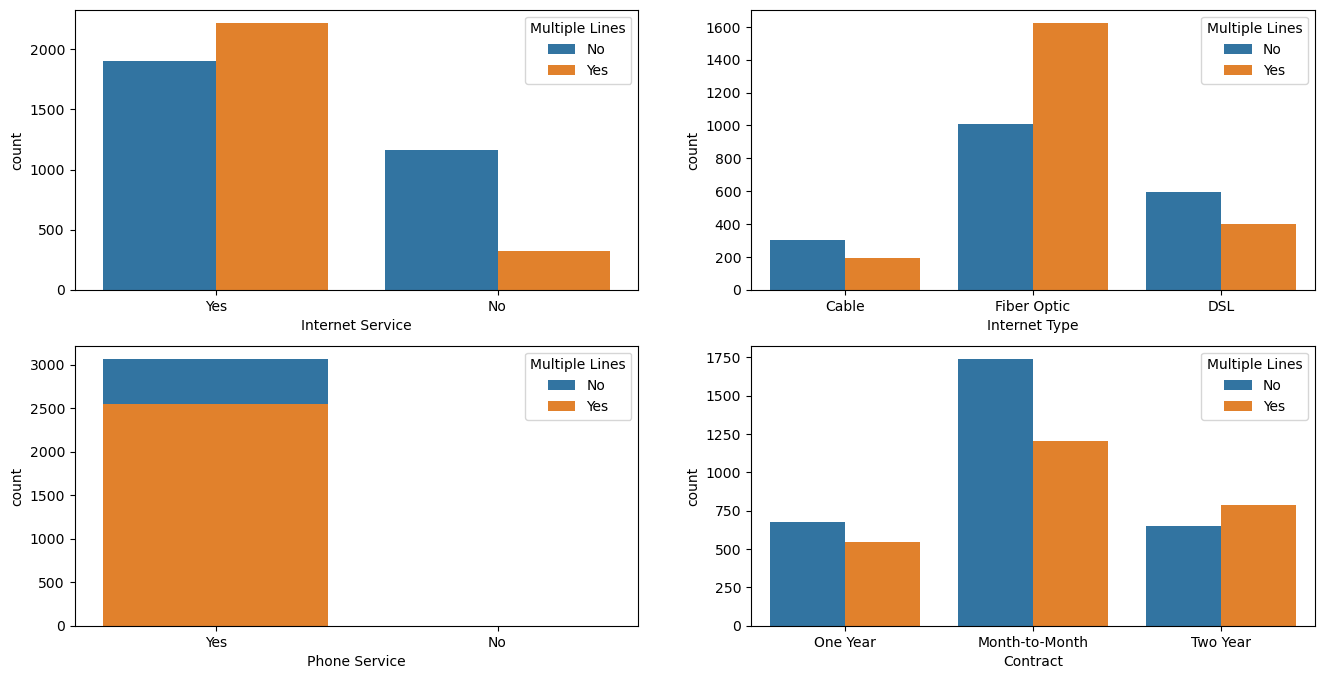

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
cols = df4[['Internet Service', 'Internet Type', 'Phone Service', 'Contract', 'Multiple Lines']]
for plot in range(4):
    i = plot // 2
    j = plot % 2
    # print(i,j)
    sns.countplot(data=df4, x=cols.columns[plot], hue='Multiple Lines', ax=axs[i,j])

In [42]:
df4[df4['Phone Service'] == 'No'].shape[0] / df4[df4['Phone Service'] == 'Yes'].shape[0] * 100
print('# Multiple Lines Nulls that correspond to Phone Service "No" values =',\
      df4[df4['Phone Service'] == 'No']['Multiple Lines'].isna().sum())
print('# Multiple Lines non-Null values that correspond to Phone Service "No" values =',\
      df4[df4['Phone Service'] == 'No']['Multiple Lines'].notna().sum())
print('# Multiple Lines Nulls that correspond to Phone Service "Yes" values =',\
      df4[df4['Phone Service'] == 'Yes']['Multiple Lines'].isna().sum())

# Multiple Lines Nulls that correspond to Phone Service "No" values = 600
# Multiple Lines non-Null values that correspond to Phone Service "No" values = 0
# Multiple Lines Nulls that correspond to Phone Service "Yes" values = 0


**Findings:**
- It appears that Multiple Lines column is Null only when Phone Service column value is "No". This makes since because a person who didn't subscribe to a phone service  can't have multiple lines. 
- Hence, we'll fill all the Multiple Line missing values with No since they only correspond to Phone Service values of "No". 

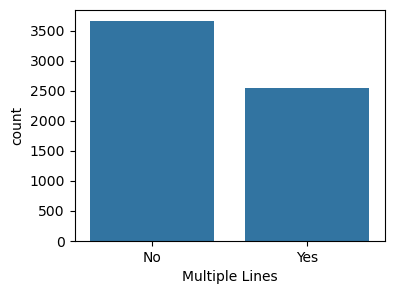

In [43]:
# Filling Multiple Lines missing values with "No"
plt.figure(figsize=(4,3))
df5['Multiple Lines'] = df5['Multiple Lines'].fillna('No')
sns.countplot(data=df5, x='Multiple Lines');

#### 3.4.2.2 Internet Type, Device Protection Plan, Premium Tech Support & Unlimited Data Columns
**Findings:** <br>
Seems that all 4 columns missing values only appear when the Internet Service Values is "No". Which makes sense since that if there is no internet service there wouldn't be any of these services as well. 

Hence we will fill the missing values for these 4 columns in the following manner:
- Internet Type: replace all the Nulls with a new fourth value "None" beside the Cable, Fiber Optic, and DSL values.
-  Device Protection Plan, Premium Tech Support, Unlimited Data: Replace all Nulls with a "No" value

In [44]:
info_plus(df5)[(info_plus(df5)['Nulls'] > 0) & (info_plus(df5)['DType'] == 'object')]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
15,Internet Type,4722,1488,object,3,"[Cable, Fiber Optic, DSL, nan]",23
16,Device Protection Plan,4722,1488,object,2,"[No, Yes, nan]",23
17,Premium Tech Support,4722,1488,object,2,"[Yes, No, nan]",23
18,Streaming TV,4722,1488,object,2,"[Yes, No, nan]",23
19,Streaming Movies,4722,1488,object,2,"[No, Yes, nan]",23
20,Streaming Music,4722,1488,object,2,"[No, Yes, nan]",23
21,Unlimited Data,4722,1488,object,2,"[Yes, No, nan]",23


##### A. Check variables dependence on the Internet Service variable column

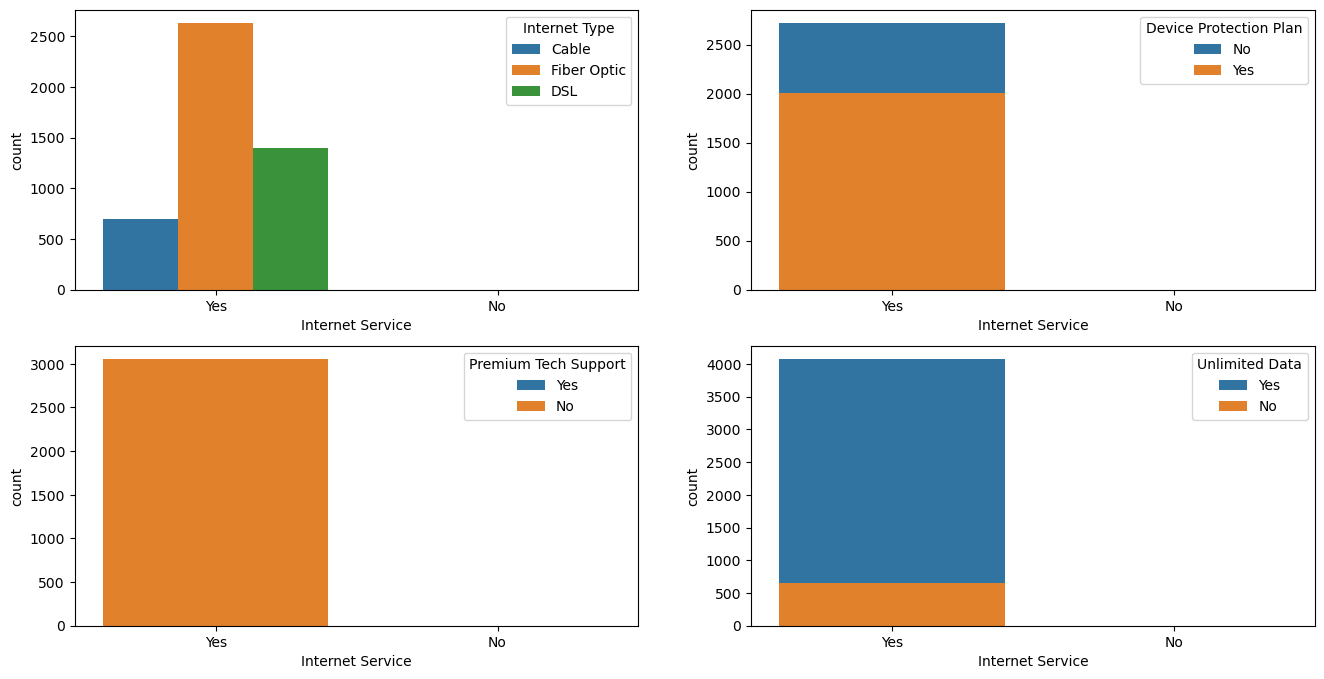

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
cols = df5[['Internet Type', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data', 'Internet Service']]
for plot in range(4):
    i = plot // 2
    j = plot % 2
    # print(i,j)
    sns.countplot(data=df5, x='Internet Service', hue=cols.columns[plot], ax=axs[i,j])

##### B. Check if all variable columns missing values correspond to Internet Service column "No" value

In [46]:
for i in range(4):
    print(f'{i+1}. {cols.columns[i]}:')
    print(f'# {cols.columns[i]} Nulls = {cols.iloc[:,i].isna().sum()}')
    print(f'# {cols.columns[i]} Nulls that correonds to Internet Service Column "No" values = {\
    cols[cols['Internet Service'] == 'No'][cols.columns[i]].isna().sum()}\n')

1. Internet Type:
# Internet Type Nulls = 1488
# Internet Type Nulls that correonds to Internet Service Column "No" values = 1488

2. Device Protection Plan:
# Device Protection Plan Nulls = 1488
# Device Protection Plan Nulls that correonds to Internet Service Column "No" values = 1488

3. Premium Tech Support:
# Premium Tech Support Nulls = 1488
# Premium Tech Support Nulls that correonds to Internet Service Column "No" values = 1488

4. Unlimited Data:
# Unlimited Data Nulls = 1488
# Unlimited Data Nulls that correonds to Internet Service Column "No" values = 1488



##### C. Findings:
Seems that all 4 columns missing values only appear when the Internet Service Values is "No". Which makes sense since that if there is no internet service there wouldn't be any of these services as well. 

Hence we will fill the missing values for these 4 columns in the following manner:
- Internet Type: replace all the Nulls with a new fourth value "None" beside the Cable, Fiber Optic, and DSL values.
-  Device Protection Plan, Premium Tech Support, Unlimited Data: Replace all Nulls with a "No" value

##### D. Replace the Missing Values for each of the columns

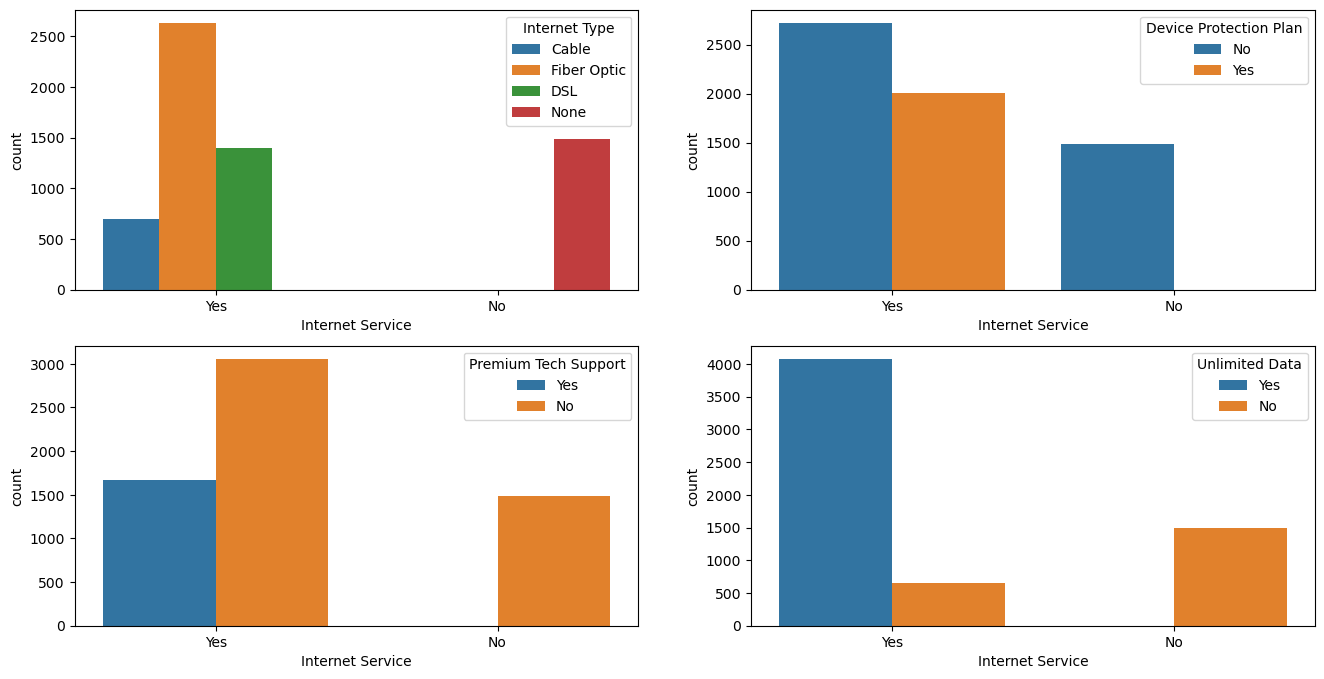

In [47]:
# Filling Internet Type missing values with a new "None" category
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
cols = df5[['Internet Type', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data', 'Internet Service']]
null_replacement = ['None', 'No', 'No', 'No']
for plot in range(4):
    i = plot // 2
    j = plot % 2
    df5[cols.columns[plot]] = df5[cols.columns[plot]].fillna(null_replacement[plot])
    sns.countplot(data=df5, x='Internet Service', hue=cols.columns[plot], ax=axs[i,j])

#### 3.4.2.3 Streaming TV, Streaming Movies & Streaming Music Columns
**Findings:** <br>
Seems that all 3 columns missing values only appear when the Internet Service Values is "No". Which makes sense since that if there is no internet service there wouldn't be any of these services as well. Hence we will fill the missing values for these 3 columns in with a "No" value

In [48]:
info_plus(df5)[(info_plus(df5)['Nulls'] > 0) & (info_plus(df5)['DType'] == 'object')]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
18,Streaming TV,4722,1488,object,2,"[Yes, No, nan]",23
19,Streaming Movies,4722,1488,object,2,"[No, Yes, nan]",23
20,Streaming Music,4722,1488,object,2,"[No, Yes, nan]",23


##### A. Check variables dependence on the Internet Service variable column

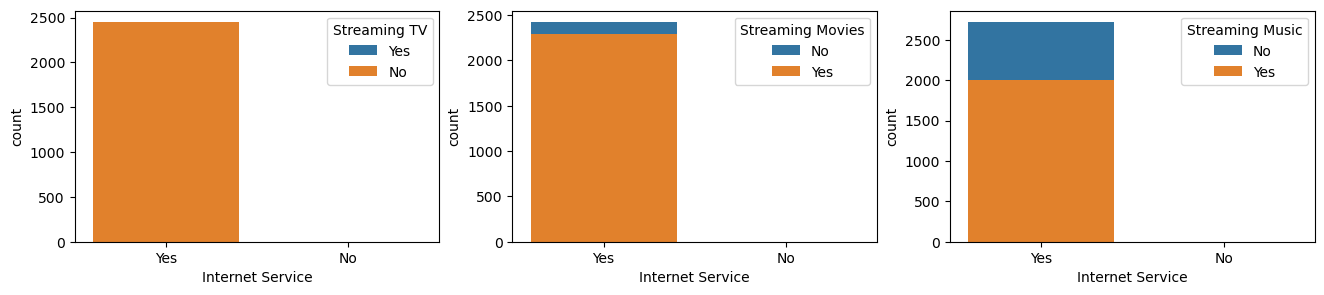

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
cols = df5[['Streaming TV', 'Streaming Movies', 'Streaming Music', 'Internet Service']]
for plot in range(3):
    sns.countplot(data=df5, x='Internet Service', hue=cols.columns[plot], ax=axs[plot])

##### B. Check if all variable columns missing values correspond to Internet Service column "No" value

In [50]:
for i in range(3):
    print(f'{i+1}. {cols.columns[i]}:')
    print(f'# {cols.columns[i]} Nulls = {cols.iloc[:,i].isna().sum()}')
    print(f'# {cols.columns[i]} Nulls that correonds to Internet Service Column "No" values = {\
    cols[cols['Internet Service'] == 'No'][cols.columns[i]].isna().sum()}\n')

1. Streaming TV:
# Streaming TV Nulls = 1488
# Streaming TV Nulls that correonds to Internet Service Column "No" values = 1488

2. Streaming Movies:
# Streaming Movies Nulls = 1488
# Streaming Movies Nulls that correonds to Internet Service Column "No" values = 1488

3. Streaming Music:
# Streaming Music Nulls = 1488
# Streaming Music Nulls that correonds to Internet Service Column "No" values = 1488



##### C. Findings:
Seems that all 3 columns missing values only appear when the Internet Service Values is "No". Which makes sense since that if there is no internet service there wouldn't be any of these services as well. Hence we will fill the missing values for these 3 columns in with a "No" value

##### D. Replace the Missing Values for each of the columns

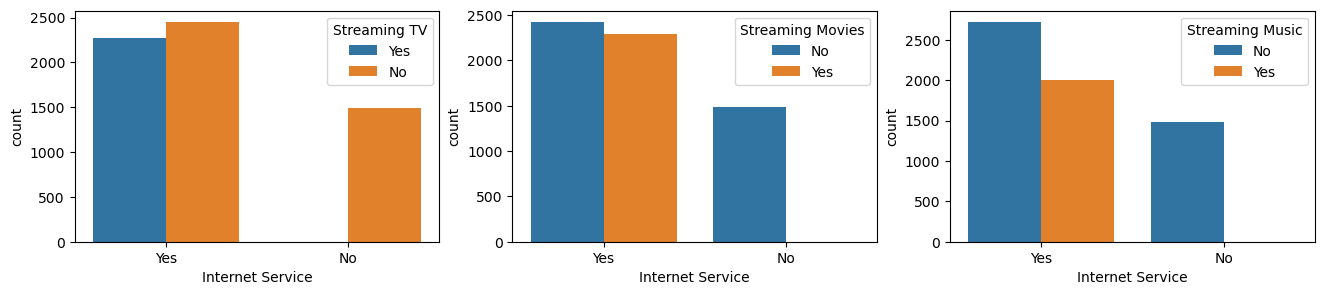

In [51]:
# Filling Internet Type missing values with a new "None" category
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
cols = df5[['Streaming TV', 'Streaming Movies', 'Streaming Music', 'Internet Service']]
null_replacement = ['No', 'No', 'No']
for plot in range(3):
    df5[cols.columns[plot]] = df5[cols.columns[plot]].fillna(null_replacement[plot])
    sns.countplot(data=df5, x='Internet Service', hue=cols.columns[plot], ax=axs[plot])

#### 3.4.2.4 Adding a Number of Services Column
**Findings:** <br>
- The 3 streaming columns behavior is similar for the Customer Status column. However, combined they provide significant information in regards to the Customer Status column, especially in the subscribers sigment that have not signed for any streaming service (# Streaming Services = 0).
- Thus we will keep the new combined column and discard of the old 3 streaming columns.

In [52]:
info_plus(df5)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,object,2,"[Female, Male]",0


##### A. Add a Number of Services column that counts the number of "Yes" values in the Streaming TV, Movies, and Music columns 

In [53]:
df5[['Streaming TV', 'Streaming Movies', 'Streaming Music']].head()

,Streaming TV,Streaming Movies,Streaming Music
0,Yes,No,No
1,No,Yes,Yes
2,No,No,No
3,Yes,Yes,No
4,Yes,No,No


In [54]:
df5['# Streaming Services'] = (df5[['Streaming TV', 'Streaming Movies', 'Streaming Music']] == 'Yes').sum(axis='columns')
df5[['Streaming TV', 'Streaming Movies', 'Streaming Music', '# Streaming Services']].head()

,Streaming TV,Streaming Movies,Streaming Music,# Streaming Services
0,Yes,No,No,1
1,No,Yes,Yes,2
2,No,No,No,0
3,Yes,Yes,No,2
4,Yes,No,No,1


##### A. Check the old and new variables relation to Customer Status Column

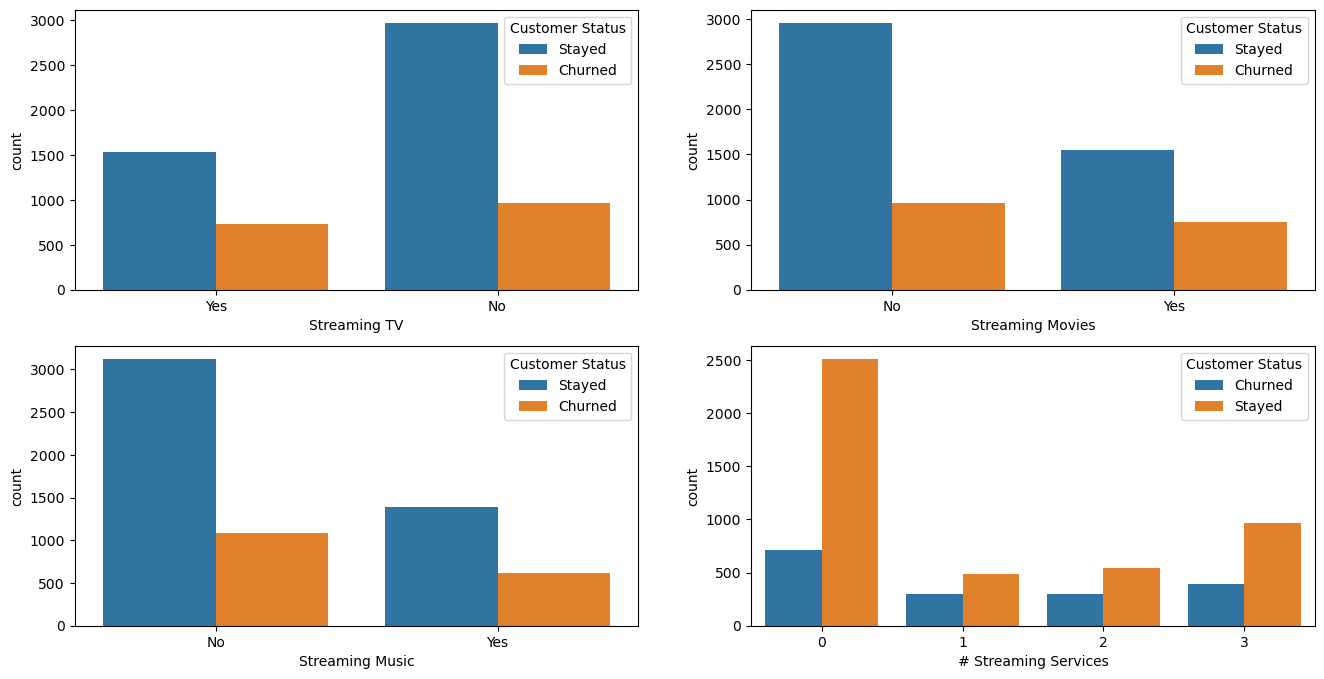

In [55]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
cols = df5[['Streaming TV', 'Streaming Movies', 'Streaming Music', '# Streaming Services', 'Customer Status']]
for plot in range(4):
    i = plot // 2
    j = plot % 2
    # print(i,j)
    sns.countplot(data=df5, x=cols.columns[plot], hue='Customer Status', ax=axs[i,j])

##### B. Findings:
- The 3 streaming columns behavior is similar for the Customer Status column. However, combined they provide significant information in regards to the Customer Status column, especially in the subscribers sigment that have not signed for any streaming service (# Streaming Services = 0).
- Thus we will keep the new combined column and discard of the old 3 streaming columns.

##### C. Remove the Streaming TV, Streaming Movies and Streaming Music columns

In [56]:
df5 = df5.drop(columns=['Streaming TV', 'Streaming Movies', 'Streaming Music'], axis=1)
info_plus(df5)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,object,2,"[Female, Male]",0


In [57]:
df_clean = df5.copy()

# 4. Encoding Categorical Data Columns

In [68]:
df_clean_enc = df_clean.copy()

In [69]:
info_plus(df_clean_enc.select_dtypes(include='object'))

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6210,0,object,2,"[Female, Male]",0
1,Married,6210,0,object,2,"[Yes, No]",0
2,City,6210,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
3,Phone Service,6210,0,object,2,"[Yes, No]",0
4,Multiple Lines,6210,0,object,2,"[No, Yes]",0
5,Internet Service,6210,0,object,2,"[Yes, No]",0
6,Internet Type,6210,0,object,4,"[Cable, Fiber Optic, DSL, None]",0
7,Device Protection Plan,6210,0,object,2,"[No, Yes]",0
8,Premium Tech Support,6210,0,object,2,"[Yes, No]",0
9,Unlimited Data,6210,0,object,2,"[Yes, No]",0


### 6.1.1 Ordinal Data:
- Contract: Month-to-Month/One Year/Two Year - 1/2/3 Label Encoder

In [70]:
dict = {'Month-to-Month':1, 'One Year':2, 'Two Year': 3}
df_clean_enc['Contract'] = df_clean_enc['Contract'].map(dict)
df_clean_enc['Contract'].unique()

array([2, 1, 3])

### 6.1.2 Nominal Data:

#### 6.1.2.1 Two State Value Columns

##### A. Gender Column: Male/Female to 1/0 -> Label Encoder

In [71]:
dict = {'Male':1, 'Female':0}
df_clean_enc['Gender'] = df_clean_enc['Gender'].map(dict)

##### B. Customer Status Column: Churned/Stayed to 1/0 -> Label Encoder

In [72]:
dict = {'Churned':1, 'Stayed':0}
df_clean_enc['Customer Status'] = df_clean_enc['Customer Status'].map(dict)

##### C. Yes/No Columns: Yes/No to 1/0 -> Label Encoder 
- Married
- Phone Service
- Multiple Lines
- Internet Service
- Device Protection Plan
- Premium Tech Support
- Unlimited Data

In [73]:
dict = {'Yes':1, 'No':0}

# Filtered names of columns with Yes/No Values
yes_no_cols = [col for col in df_clean_enc.columns if set(df_clean_enc[col].unique()).issubset(['Yes','No'])] 
print('Yes or No column names:\n', yes_no_cols)

# encode yes/no columns
df_clean_enc[yes_no_cols] = df_clean_enc[yes_no_cols].apply(lambda x: x.map(dict))

Yes or No column names:
 ['Married', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']


#### 6.1.2.3 Multi-State Value Columns -> Binary Encoder

##### A. Internet Type Column:

In [74]:
# Remaining categorical columns
cat_cols = df_clean_enc.select_dtypes(include='object').columns.to_list()
print('Multi-State Values (>2) Category Encoders:\n', cat_cols)
encoder = ce.BinaryEncoder(cols=cat_cols)
df_clean_enc = encoder.fit_transform(df_clean_enc)

Multi-State Values (>2) Category Encoders:
 ['City', 'Internet Type']


In [75]:
info_plus(df_clean_enc)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,int64,2,"[0, 1]",0


##### B. City Column:

In [ ]:
# # Remaining categorical columns
# df3_cat_cols = df3.select_dtypes(include='object').columns
# print(df3_cat_cols)
# encoder = ce.BinaryEncoder(cols=df3_cat_cols)
# df3 = encoder.fit_transform(df3)

In [ ]:
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']] = \
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda x: x.map({'Yes':1, 'No':0}))
# # # df2['Streaming TV'] = df2['Streaming TV'].map({'Yes':1, 'No':0})
# # # df2['Streaming Movies'] = df2['Streaming Movies'].map({'Yes':1, 'No':0})
# # # df2['Streaming Music'] = df2['Streaming Music'].map({'Yes':1, 'No':0})
# data['# Streaming Services'] = df2['Streaming TV'] + df2['Streaming Movies'] + df2['Streaming Music']
# # info_plus(df2)
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].shape
# df2.head()
# info_plus(df2)

In [ ]:
# data['# Streaming Services'] = df2['# Streaming Services']
# sns.countplot(data=data, x='# Streaming Services', hue='Customer Status', ax=axs[i]);

In [ ]:
# data.head()

In [ ]:
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']] = \
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda x: x.map({'Yes':1, 'No':0}))
# # # df2['Streaming TV'] = df2['Streaming TV'].map({'Yes':1, 'No':0})
# # # df2['Streaming Movies'] = df2['Streaming Movies'].map({'Yes':1, 'No':0})
# # # df2['Streaming Music'] = df2['Streaming Music'].map({'Yes':1, 'No':0})
# data['# Streaming Services'] = df2['Streaming TV'] + df2['Streaming Movies'] + df2['Streaming Music']
# # info_plus(df2)
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].shape
# df2.head()
# info_plus(df2)

In [ ]:
# data['# Streaming Services'] = df2['# Streaming Services']
# sns.countplot(data=data, x='# Streaming Services', hue='Customer Status', ax=axs[i]);

In [ ]:
# data.head()

Fixing Class Imbalance in Customer Status column:
We will perform oversampling on the "Churned" rows class with SMOTE

In [ ]:
# df3.to_csv('data/telecom_customer_churn_clean.csv', index=False)

In [ ]:
# df2.to_csv('data/telecom_customer_churn_clean_not_encoded.csv', index=False)

Fixing Class Imbalance in Customer Status column:
We will perform oversampling on the "Churned" rows class with SMOTE

In [ ]:
# df3.to_csv('data/telecom_customer_churn_clean.csv', index=False)

In [ ]:
# df2.to_csv('data/telecom_customer_churn_clean_not_encoded.csv', index=False)

In [ ]:
# df2[cat_null_cols_info.iloc[:,0]].describe()

In [ ]:
# # Data Series of categorical columns with Nulls
# nan_cols = cat_null_cols_info.iloc[:,0]

# # Filling missing values with mode of columns (most frequent value)
# df2[nan_cols] = df2[nan_cols].fillna(df2[nan_cols].mode().iloc[0])

# info_plus(df2)

# # testing outputs:
# #df2[nan_cols].mode()[0]
# #df2['nan_cols']
# #print(df2[nan_cols].mode().iloc[0])

**Findings:** All missing values have been filled

# 4. Data Visualization

## 4.1 Univariate Analysis

In [ ]:
df2_num_cols = df2.select_dtypes(include='number')
info_plus(df2_num_cols)

### 4.1.1 Univariate Analysis for Numerical Columns

**Findings:**
1. Age:
    - Although the general histogram shows that most user ages are between 19 to 25, a more detailed histogram (bin size = 1) shows that users are homogeniously distributed ranging from 100-140 user in the ages between 19 to 63. Retired indivuduals or people over 63 are the least subscribers to the service.
    - From the boxplot, the median is approximately 56 with %50 of users between the ages of 33 and 60 and %75 below 60.
2. Number of Dependents:
3. Number of Referrals
4. Tenure in Months
5. Avg Monthly GB Download
6. Total Refunds
7. Total Extra Data Charges
8. Total Long Distance Charges
9. Total Charges:

- Histogram for all numerical columns (birdeye's view)

In [ ]:
df2_num_cols.hist(figsize=(14,9));

#### 4.1.1.1 Age

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Age']
plt.hist(data, bins=data.nunique()-1, edgecolor='black', color='red', align='left');
plt.xlabel('Age')

# BoxPlot
plt.subplot(1,2,2)
sns.boxplot(data=df2['Age'], orient='h', color='r')

**Findings:**
- Although the general histogram shows that most user ages are between 19 to 25, a more detailed histogram (bin size = 1) shows that users are homogeniously distributed ranging from 100-140 user in the ages between 19 to 63. Retired indivuduals or people over 63 are the least subscribers to the service.
- From the boxplot, the median is approximately 56 with %50 of users between the ages of 33 and 60 and %75 below 60.

#### 4.1.1.2 Number of Dependents

In [ ]:
# plt.figure(figsize=(16, 4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
# Histogram
data = df_num_cols['Number of Dependents']
ax[0].hist(data, bins=data.nunique()-1, edgecolor='black', color='g', align='left', rwidth=0.5);
ax[0].set_xlabel('Number of Dependents')

# Pie Chart
data = df_num_cols['Number of Dependents']
ax[1].pie(data.value_counts(), labels=data.value_counts().index, autopct = '%1.0f%%', explode=[0.1]*data.nunique())
ax[1].set_xlim(-1,2)
ax[1].set_xlabel('Number of Dependents')
plt.legend(loc='upper right')
plt.show();

**Findings:**
- Most users (%77) don't have dependents, which means they are mostly single.

#### 4.1.1.1 Number of Dependents, Number of Referrals & Tenure in Months

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Number of Dependents']
plt.hist(data, bins=data.nunique(), edgecolor='black', color='g', align='mid');
plt.xlabel('Number of Dependents')

# BoxPlot
plt.subplot(1,2,2)
ax = sns.boxplot(data=df2['Number of Dependents'], orient='h', color='g')

**Findings:**
- Age: Most subscribers are 19-25 years old, and least ones are over 60
- Dependents: Most subscribers have only one dependent

#### 4.1.1.1 Number of Dependents, Number of Referrals & Tenure in Months

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Number of Dependents']
plt.hist(data, bins=data.nunique(), edgecolor='black', color='g', align='mid');
plt.xlabel('Number of Dependents')

# BoxPlot
plt.subplot(1,2,2)
ax = sns.boxplot(data=df2['Number of Dependents'], orient='h', color='g')

**Findings:**
- Age: Most subscribers are 19-25 years old, and least ones are over 60
- Dependents: Most subscribers have only one dependent

#### 4.1.1.1 Number of Dependents, Number of Referrals & Tenure in Months

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Number of Dependents']
plt.hist(data, bins=data.nunique(), edgecolor='black', color='g', align='mid');
plt.xlabel('Number of Dependents')

# BoxPlot
plt.subplot(1,2,2)
ax = sns.boxplot(data=df2['Number of Dependents'], orient='h', color='g')

**Findings:**
- Age: Most subscribers are 19-25 years old, and least ones are over 60
- Dependents: Most subscribers have only one dependent

#### 4.1.1.1 Number of Dependents, Number of Referrals & Tenure in Months

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Number of Dependents']
plt.hist(data, bins=data.nunique(), edgecolor='black', color='g', align='mid');
plt.xlabel('Number of Dependents')

# BoxPlot
plt.subplot(1,2,2)
ax = sns.boxplot(data=df2['Number of Dependents'], orient='h', color='g')

**Findings:**
- Age: Most subscribers are 19-25 years old, and least ones are over 60
- Dependents: Most subscribers have only one dependent

#### 4.1.1.1 Number of Dependents, Number of Referrals & Tenure in Months

In [ ]:
plt.figure(figsize=(16, 4))

# Histogram
plt.subplot(1,2,1)
data = df_num_cols['Number of Dependents']
plt.hist(data, bins=data.nunique(), edgecolor='black', color='g', align='mid');
plt.xlabel('Number of Dependents')

# BoxPlot
plt.subplot(1,2,2)
ax = sns.boxplot(data=df2['Number of Dependents'], orient='h', color='g')

**Findings:**
- Age: Most subscribers are 19-25 years old, and least ones are over 60
- Dependents: Most subscribers have only one dependent

### 4.1.2 Univariate Analysis for Categorical Columns

In [ ]:
# Replacing Contract column categories with shorter names for shorter plot xlabels
df2['Contract'] = df2['Contract'].map({'One Year':'1-Y', 'Month-to-Month':'M-to-M', 'Two Year':'2-Y'})

In [ ]:
df2_cat_cols = df2.select_dtypes(include='object')
info_plus(df2_cat_cols)

In [ ]:
# Dropping cities from df2_cat_cols because of its huge number of categories (1106)
df2_cat_cols.drop(columns=['City'], axis=1, inplace=True)
info_plus(df2_cat_cols)

In [ ]:
# Barcharts for all categorical columns (birdeye's view)
fig, axs = plt.subplots(4, 4, figsize=(14, 14))
df2_cat_cols.columns

# printing each subplot separately
for plot, col in enumerate(df2_cat_cols.columns):
    # changing subplot index from 0->11 to row x col format
    i = plot // 4
    j = plot % 4
    print(i,j)
    # counts = df2_cat_cols[col].value_counts()
    # counts.plot(kind='bar', ax=axs[i,j], title=col, xlabel='', rot=0)

#### 4.1.2.1 Checking Target Columns/Variable for Class Imbalances

In [ ]:
print(f"Percentage of Stayed subscribers = %", ((df2['Customer Status'] == 'Stayed').sum())/df2.shape[0]*100)
print(f"Percentage of Stayed subscribers = %", ((df2['Customer Status'] == 'Churned').sum())/df2.shape[0]*100)

**Findings:**
This is an imbalanced class since 1 of the classes quota is above %60 of the total number of records. We will deal with that in the Feature Engineering phase. 

## 4.2 Bivariate Analysis

In [ ]:
# # df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']] = \
# # df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda x: x.map({'Yes':1, 'No':0}))
# # # # df2['Streaming TV'] = df2['Streaming TV'].map({'Yes':1, 'No':0})
# # # df2['Streaming Movies'] = df2['Streaming Movies'].map({'Yes':1, 'No':0})
# # # df2['Streaming Music'] = df2['Streaming Music'].map({'Yes':1, 'No':0})
# df2['# Streaming Services'] = df2['Streaming TV'] + df2['Streaming Movies'] + df2['Streaming Music']
# info_plus(df2)

In [ ]:
# data = df2[['Streaming TV', 'Streaming Movies', 'Streaming Music', 'Customer Status']]
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
# for i in range(3):
#     sns.countplot(data=data, x='Customer Status', hue=data.columns[i], ax=axs[i])

In [ ]:
# # data['# Streaming Services'] = df2['# Streaming Services']
# data = df2[['Streaming TV', 'Streaming Movies', 'Streaming Music', '# Streaming Services', 'Customer Status']]
# sns.countplot(data=data, x='Customer Status', hue='# Streaming Services')
# data.head()

# 5. Data Insights

# 6. Basic Feature Engineering 

In [ ]:
# info_plus(df2.select_dtypes(include='object'))

### 6.1.1 Ordinal Data:

In [ ]:
# df3 = df2.copy()

In [ ]:
# # Label Encoder:
# dict = {'M-to-M':1, '1-Y':2, '2-Y': 3}
# df3['Contract'] = df2['Contract'].map(dict)

### 6.1.2 Nominal Data:

- Two state encoding yes/no to 1/0 -> Label Encoder

In [ ]:
# # Gender Column
# dict1 = {'Male':1, 'Female':0}
# df3['Gender'] = df3['Gender'].map(dict1)

# # Customer Status Column
# dict2 = {'Churned':1, 'Stayed':0}
# df3['Customer Status'] = df3['Customer Status'].map(dict2)

# # Columns of Yes/No as unique values
# dict3 = {'Yes':1, 'No':0}

# # Columns with values of Yes/No
# # Filtered names of columns with Yes/No Values
# df3_cat_yes_no_cols = [col for col in df3.columns if set(df3[col].unique()).issubset(['Yes','No'])] 
# print(df3_cat_yes_no_cols)
# df3[df3_cat_yes_no_cols] = df3[df3_cat_yes_no_cols].apply(lambda x: x.map(dict3))

- More than two states encoding -> Binary Encoder

In [ ]:
# # Remaining categorical columns
# df3_cat_cols = df3.select_dtypes(include='object').columns
# print(df3_cat_cols)
# encoder = ce.BinaryEncoder(cols=df3_cat_cols)
# df3 = encoder.fit_transform(df3)

In [ ]:
# info_plus(df3)

- Since all the 3 column nulls appear in the same rows simultaneously, we can combine the 3 columns now and fill in the missing value for the newely created 'Streaming Services Column' later.

In [ ]:
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']] = \
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda x: x.map({'Yes':1, 'No':0}))
# # # df2['Streaming TV'] = df2['Streaming TV'].map({'Yes':1, 'No':0})
# # # df2['Streaming Movies'] = df2['Streaming Movies'].map({'Yes':1, 'No':0})
# # # df2['Streaming Music'] = df2['Streaming Music'].map({'Yes':1, 'No':0})
# data['# Streaming Services'] = df2['Streaming TV'] + df2['Streaming Movies'] + df2['Streaming Music']
# # info_plus(df2)
# df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].shape
# df2.head()
# info_plus(df2)

In [ ]:
# data['# Streaming Services'] = df2['# Streaming Services']
# sns.countplot(data=data, x='# Streaming Services', hue='Customer Status', ax=axs[i]);

In [ ]:
# data.head()

Fixing Class Imbalance in Customer Status column:
We will perform oversampling on the "Churned" rows class with SMOTE

In [76]:
df_clean.to_csv('data/data_clean_new.csv', index=False)

In [77]:
df_clean_enc.to_csv('data/data_clean_encoded_new.csv', index=False)

In [78]:
info_plus(df_clean)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,object,2,"[Female, Male]",0


In [79]:
info_plus(df_clean_enc)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Age,6210,0,float64,62,"[37.0, 46.0, 50.0, 78.0, 75.0]",0
1,Number of Dependents,6210,0,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0]",0
2,Number of Referrals,6210,0,float64,12,"[2.0, 0.0, 1.0, 3.0, 8.0]",0
3,Tenure in Months,6210,0,float64,72,"[9.0, 4.0, 13.0, 3.0, 71.0]",0
4,Avg Monthly GB Download,6210,0,float64,170,"[16.0, 10.0, 30.0, 4.0, 11.0]",0
5,Total Charges,6210,0,float64,5764,"[593.3, 542.4, 280.85, 1237.85, 267.4]",0
6,Total Refunds,6210,0,float64,447,"[0.0, 38.33, 21.25, 30.53, 44.42]",0
7,Total Extra Data Charges,6210,0,float64,16,"[0.0, 10.0, 20.0, 120.0, 40.0]",0
8,Total Long Distance Charges,6210,0,float64,5364,"[381.51, 96.21, 134.6, 361.66, 22.14]",0
9,Gender,6210,0,int64,2,"[0, 1]",0
